In [1]:
###Importing dependencies
using Pkg
Pkg.activate("../")
using DataFrames, MClassification, MLJ, Queryverse, Plots
include("../src/io.jl")

 Activating environment at `~/.julia/dev/MClassifier/Project.toml`
┌ Info: Precompiling MClassification [7aadbe48-82bb-4990-b1ce-71777a0f3ceb]
└ @ Base loading.jl:1260
┌ Warning: Package MClassification does not have DataFrames in its dependencies:
│ - If you have MClassification checked out for development and have
│   added DataFrames as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with MClassification
└ Loading DataFrames into MClassification from project dependency, future warnings for MClassification are suppressed.
┌ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1260
[ Info: Model metadata loaded from registry. 


load_sample (generic function with 1 method)

In [2]:
###Setting path of the datasets and getting their names
path = "../datasets/sinthetic/"
datasets = split(read(`ls $path`, String), "\n")[1:end-1]
dados = Queryverse.load(path * datasets[end], header_exists=false) |> DataFrame
schema(dados)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ Column1 │ Float64 │ Continuous │
│ Column2 │ Float64 │ Continuous │
│ Column3 │ Float64 │ Continuous │
│ Column4 │ Float64 │ Continuous │
│ Column5 │ Float64 │ Continuous │
│ Column6 │ Int64   │ Count      │
└─────────┴─────────┴────────────┘
_.nrows = 200000


In [32]:
@load KNNClassifier

y = dados[:,end]
X = dados[:,1:end-1]
training_set_size = 150
y_predicted = [Array{Any, 1}() for i in 1:2]

###KNN
knn = KNNClassifier(K=3)
knn = MLJ.machine(knn, X, coerce(y, autotype(y)))
train = collect(1:training_set_size)
test = collect(training_set_size+1:length(y))
MLJ.fit!(knn, rows=train)
y_predicted[1] = predict_mode(knn, rows=test)

###MClassification
mClassifier = MClassification.fit(X[1:150, :], y[1:150], 0.1)
y_predicted[2] = MClassification.predict(mClassifier, convert(Array{Float64, 2}, X[151:end, :]))

n_instances = 0

┌ Info: A model type "KNNClassifier" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /home/coiote/.julia/packages/MLJModels/zduEi/src/loading.jl:43
┌ Info: Training Machine{KNNClassifier} @ 1…18.
└ @ MLJBase /home/coiote/.julia/packages/MLJBase/uJ1jK/src/machines.jl:182


199850

0

In [71]:
length(y_predicted[1])

199850

In [73]:
hates = [Array{Float64, 1}() for i in 1:2]
hits = zeros(Int64, 2)

for i in 1:length(y_predicted[2]) 
    n_instances += 1
    
    if y[i+150] == y_predicted[1][i]
        hits[1] += 1
    end
        
    if y[i+150] == y_predicted[2][i]
        hits[2] += 1
    end
    
    if n_instances % 2000 == 0
            append!(hates[1], hits[1] / 2000)
            append!(hates[2], hits[2] / 2000)
            hits[1] = 0
            hits[2] = 0
        
    end
end



    


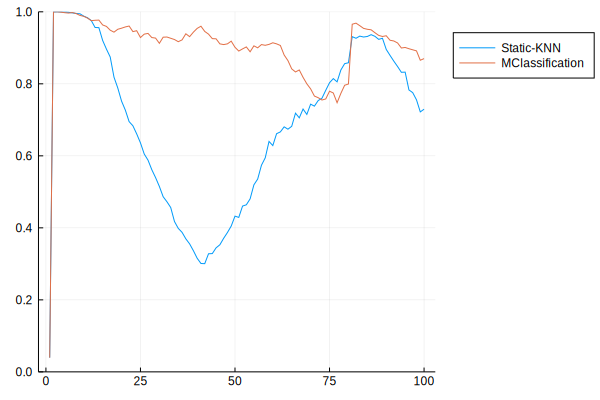

In [86]:
plot(hates, ylims = (0, 1), labels = permutedims(["Static-KNN", "MClassification"]), legend=:outertopright)